# BLa BLA BLA

... ... 

In [1]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
import string
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from math import log, sqrt
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pk
import numpy as np
import glob
import os
from collections import Counter
from pandas import DataFrame, read_csv
import matplotlib.pyplot as plt
from stop_words import get_stop_words
from string import punctuation

STOPWORDS = get_stop_words('dutch')

In [2]:
def preprocess(doc):
    if type(doc) is str:
        doc = doc.lower()
        doc = doc.translate(str.maketrans({key: " " for key in string.punctuation}))
        doc = " ".join([w for w in doc.split() if w not in STOPWORDS])
        return doc
    else:
        print('Received non-string input, returning empty string')
        return ''

In [4]:
def get_traintest(df, test_size=.30):
    '''takes dataframe, selects relevant part, preprocesses text and returns train, test data lists with 
    (text, label) tuples'''
    rows = df[['Platte tekst (zonder opmaak)','Misinfo Nee(1) Ja(0)']].dropna().to_records(index=False)
    rowsclean = []
    for e in rows:
        try:
            rowsclean.append((preprocess(e[0]), int(e[1])))
        except ValueError:
            pass
    train, test = train_test_split(rowsclean, test_size=test_size)
    return train, test

In [5]:
hpv = pd.read_csv('hpv.csv')
childhood = pd.read_csv('childhood.csv')

In [6]:
hpv_train, hpv_test = get_traintest(hpv)
print("Obtained {} train and {} test tuples for HPV".format(len(hpv_train), len(hpv_test)))

childhood_train, childhood_test = get_traintest(childhood)
print("Obtained {} train and {} test tuples for childhood vaccination".format(len(childhood_train), len(childhood_test)))
    

Obtained 138 train and 60 test tuples for HPV
Obtained 316 train and 136 test tuples for childhood vaccination


In [19]:
def ml(train, test):
    myvec = TfidfVectorizer()
    train_features = myvec.fit_transform([e[0] for e in train])
    test_features = myvec.transform([e[0] for e in test])
    model  = LogisticRegression()
    model.fit(train_features, [e[1] for e in train])
    predictions = model.predict(test_features)
    predicted_probabilities = model.predict_proba(test_features)
    return predictions, predicted_probabilities

In [8]:
def performance(predictions, actual_scores):
    accuracy=metrics.accuracy_score(actual_scores,predictions,normalize=True)
    recall=metrics.recall_score(actual_scores,predictions,pos_label=1,labels=['0','1'])
    recall_incl=metrics.recall_score(actual_scores,predictions,pos_label=0,labels=['0','1'])
    precision=metrics.precision_score(actual_scores,predictions,pos_label=1,labels=['0','1'])
    precision_incl=metrics.precision_score(actual_scores,predictions,pos_label=0,labels=['1','0'])
    confusionmatrix=metrics.confusion_matrix(actual_scores,predictions)
    print('Accuracy:',accuracy,
          '\nRecall:',recall,
          '\nNote: Recall if we are interested in predicting inclusion of entries:',recall_incl,
          '\nPrecision:',precision,
          '\nNote: Precision if we are interested in predicting inclusion of entries:',precision_incl,
          '\nConfusion Matrix:','\n',confusionmatrix)


In [21]:
def roc_curve(predicted_probabilities, actual_scores):
    fpr, tpr, thresholds = metrics.roc_curve(actual_scores, predicted_probabilities[:,1],pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)
    print("ROC AUC:\n{}".format(roc_auc))
    #%%
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


Accuracy: 0.9411764705882353 
Recall: 0.9887640449438202 
Note: Recall if we are interested in predicting inclusion of entries: 0.851063829787234 
Precision: 0.9263157894736842 
Note: Precision if we are interested in predicting inclusion of entries: 0.975609756097561 
Confusion Matrix: 
 [[40  7]
 [ 1 88]]
ROC AUC:
0.980635907243605


/home/damian/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


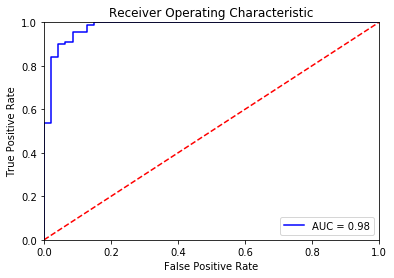

In [22]:
predictions, probabilities = ml(childhood_train, childhood_test)
performance(predictions, [e[1] for e in childhood_test])
roc_curve(probabilities, [e[1] for e in childhood_test])

Accuracy: 0.6666666666666666 
Recall: 1.0 
Note: Recall if we are interested in predicting inclusion of entries: 0.13043478260869565 
Precision: 0.6491228070175439 
Note: Precision if we are interested in predicting inclusion of entries: 1.0 
Confusion Matrix: 
 [[ 3 20]
 [ 0 37]]
ROC AUC:
0.8695652173913043


/home/damian/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


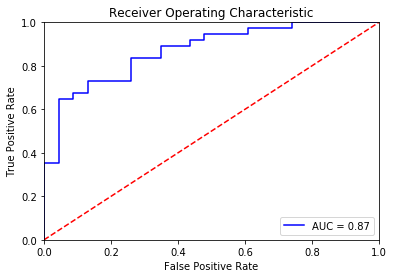

In [23]:
predictions, probabilities = ml(hpv_train, hpv_test)
performance(predictions, [e[1] for e in hpv_test])
roc_curve(probabilities, [e[1] for e in hpv_test])

# oud of sample prediction

Accuracy: 0.75 
Recall: 0.9459459459459459 
Note: Recall if we are interested in predicting inclusion of entries: 0.43478260869565216 
Precision: 0.7291666666666666 
Note: Precision if we are interested in predicting inclusion of entries: 0.8333333333333334 
Confusion Matrix: 
 [[10 13]
 [ 2 35]]
ROC AUC:
0.8354876615746182


/home/damian/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


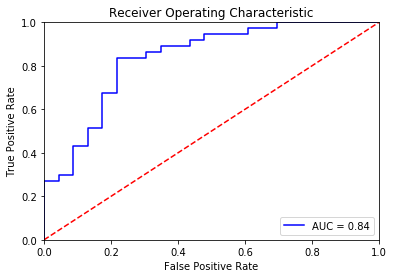

In [25]:
predictions, probabilities = ml(childhood_train, hpv_test)
performance(predictions, [e[1] for e in hpv_test])
roc_curve(probabilities, [e[1] for e in hpv_test])

# oude scratch

In [ ]:
#Count_NB
#train & show performance
m1_nb = MultinomialNB()
m1_nb.fit(train_features_count, train_scores)
m1_predictions = m1_nb.predict(test_features_count)
performance(m1_predictions)
#%%
#Save
pk.dump(count_vectorizer,open('count_vectorizer.pkl',mode='wb'))
joblib.dump(m1_nb,'nb_classifier_count.pkl')
#%%
#tf-idf_NB
m2_nb = MultinomialNB()
m2_nb.fit(train_features_tfidf, train_scores)
m2_predictions = m2_nb.predict(test_features_tfidf)
performance(m2_predictions)
#%%
pk.dump(tfidf_vectorizer,open('tfidf_vectorizer.pkl',mode='wb'))
joblib.dump(m2_nb,'nb_classifier_tfidf.pkl')
#%%
#Count_LR
m3_logreg = LogisticRegression()
m3_logreg.fit(train_features_count, train_scores)
m3_predictions = m3_logreg.predict(test_features_count)
performance(m3_predictions)
#%%
joblib.dump(m3_logreg, 'logreg_classifier.pkl')
#%%
#tf-idf_LR
m4_logreg = LogisticRegression()
m4_logreg.fit(train_features_tfidf, train_scores)
m4_predictions = m4_logreg.predict(test_features_tfidf)
performance(m4_predictions)
#%%
joblib.dump(m4_logreg, 'logreg_classifier_tfidf.pkl')
#%%
#make ROCs
m1_predict_probabilities = m1_nb.predict_proba(test_features_count)
fpr, tpr, thresholds = metrics.roc_curve(actual_scores, m1_predict_probabilities[:,1],pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
print("ROC AUC:\n{}".format(roc_auc))
#%%
m2_predict_probabilities = m2_nb.predict_proba(test_features_tfidf)
fpr, tpr, thresholds = metrics.roc_curve(actual_scores, m2_predict_probabilities[:,1],pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
print("ROC AUC:\n{}".format(roc_auc))
#%%
m3_predict_probabilities = m3_logreg.predict_proba(test_features_count)
fpr, tpr, thresholds = metrics.roc_curve(actual_scores, m3_predict_probabilities[:,1],pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
print("ROC AUC:\n{}".format(roc_auc))
#%%